In [0]:
  # # This code to link colab to a drive account
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# code_dir = 'drive/My Drive/CG Detection/'   # Code directory
# try:
#   os.chdir(code_dir)
# except Exception as e:
#   print(e)

In [0]:
import random
import numbers
from tqdm import tqdm
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as F
from torchvision.transforms import RandomCrop, CenterCrop
import cv2
import os
import numpy as np
from PIL import Image

In [0]:
def get_output_size(img, container):
    # get image size
    img_w, img_h = img.size

    # get cropping parameters
    per = container[0]
    min_dim = container[1]

    # function to generate random number in the range (per - 1)
    rand_num = lambda pr: pr + (1 - pr)*random.random()


    output_size = (int(img_h * rand_num(per)), int(img_w * rand_num(per)))
    output_size = (max(output_size[0], min_dim), max(output_size[1], min_dim))
    return output_size

In [0]:
class NRandomCrop(RandomCrop):
    """ Take N different random crops from the image by cropping"""
    def __init__(self, size, n, mode = 'number', padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode
        self.n = n
        self.mode = mode
    
    @staticmethod
    def get_params(img, output_size, n):
        """Get parameters for ``crop`` for n random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
            n (integer): Expected number of crops
        Returns:
            tuple: n random crops.
        """
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w
            
        i = [random.randint(0, (h - th)) for i in range(n)]
        j = [random.randint(0, (w - tw)) for i in range(n)]
        return i, j, th, tw
    
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            tuple of PIL Images: Cropped images.
        """
        if self.padding is not None:
            img = F.pad(img, self.padding, self.fill, self.padding_mode)

        # pad the width if needed
        if self.pad_if_needed and img.size[0] < self.size[1]:
            img = F.pad(img, (self.size[1] - img.size[0], 0), self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and img.size[1] < self.size[0]:
            img = F.pad(img, (0, self.size[0] - img.size[1]), self.fill, self.padding_mode)
            
        if self.mode == 'percentage':
            output_size = get_output_size(img, self.size)
            
        elif self.mode == 'number':
            output_size = self.size
        else:
            output_size = None
            
        i, j, h, w = self.get_params(img, output_size, self.n)

        crops = []
        for cr in range(self.n):
            crops.append(img.crop((j[cr], i[cr], j[cr] + w, i[cr] + h)))

        return tuple(crops)

In [0]:
class NCenterCrop(CenterCrop):
    """ Take N different random crops from the image by rotation"""
    def __init__(self, size, n, mode = 'number', padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode
        self.n = n
        self.mode = mode

    
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            tuple of PIL Images: Cropped images.
        """
        if self.mode == 'percentage':
            output_size = get_output_size(img, self.size)
            
        elif self.mode == 'number':
            output_size = self.size
        else:
            output_size = None
        
        rotate = [random.randrange(-180, 180, 10) for i in range(self.n)]
        images = [F.rotate(img, angle) for angle in rotate]
        
        crops = []
        for img in images:
            crops.append(F.center_crop(img, output_size))
            
        return tuple(crops)

In [0]:
class LightnessCompensation(object):
    """
    Class for lightness compensation
    Refer to : https://medium.com/@shashiranjan96kgp/diabetic-retinopathy-detection-using-deep-learning-5275ee283805
    """

    def __init__(self, p=0.5):
        pass

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: image after the lightness compensation
        """
        # Convert the image into numpy array
        img = np.asarray(img)
        
        # Calculate the eyeball radius
        middle_row = img[int(img.shape[0]/2),:,:].sum(1)   # sum over channel
        radius = int((middle_row > middle_row.mean()/10).sum()/2)

        # The center of the circle
        x = int(img.shape[1]/2)
        y = int(img.shape[0]/2)

        eyeball = np.zeros(img.shape, dtype = np.uint8)
        cv2.circle(eyeball, (x, y) , radius, (1,1,1), -1, 8, 0)

        # Extract the necessary parts
        img = img * eyeball
        im_blurred = cv2.GaussianBlur(img, (0,0), 10)
        
        return Image.fromarray(cv2.addWeighted(img, 4, im_blurred, -4, 128)*eyeball)
    

In [0]:
class Histogram_equalization:
    def __init__(self):
        pass

    
    def __call__(self, image):
        """
        Args:
            img (PIL Image).
        Returns:
            PIL Image.
        """
        img = np.array(image)
        b = img[:,:,0]
        g = img[:,:,1]
        r = img[:,:,2]


        hist_b = cv2.equalizeHist(b)
        hist_g = cv2.equalizeHist(g)
        hist_r = cv2.equalizeHist(r)
        
        res_img = cv2.merge((hist_b, hist_g, hist_r))
        res_img = Image.fromarray(res_img)
        return res_img

In [0]:
class CLAHE:
    """ Adaptive Histogram Equalization """
    def __init__(self):
        pass

    
    def __call__(self, image):
        """
        Args:
            img (PIL Image).
        Returns:
            PIL Image.
        """
        img = np.array(image)
        b = img[:,:,0]
        g = img[:,:,1]
        r = img[:,:,2]


        clahe = cv2.createCLAHE()

        CLAHE_b = clahe.apply(b)
        CLAHE_g = clahe.apply(g)
        CLAHE_r = clahe.apply(r)
        
        res_img = cv2.merge((CLAHE_b, CLAHE_g, CLAHE_r))
        res_img = Image.fromarray(res_img)
        return res_img

In [0]:
# # For test purpose
# import matplotlib.pyplot as plt
# from PIL import Image
# dataset_dir = 'Dataset/'   # Dataset directory
# root_dir = os.path.join(os.getcwd(), dataset_dir)
# dataset_folder = ImageFolder(root_dir, transform=NCenterCrop(224, 3, 'number'))


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.20it/s]


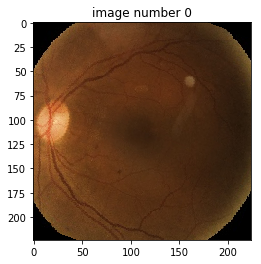

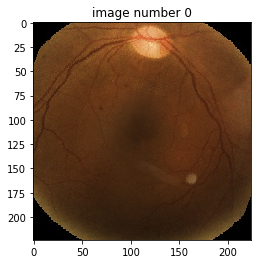

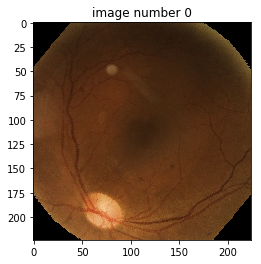

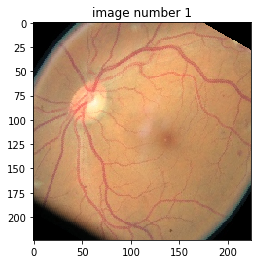

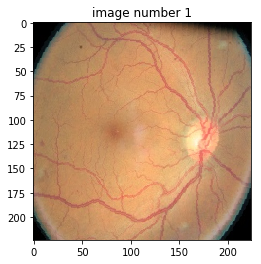

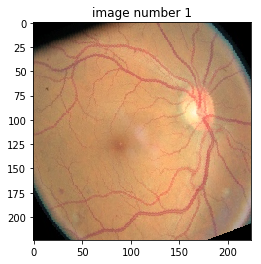

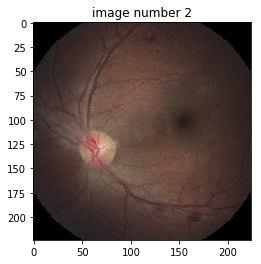

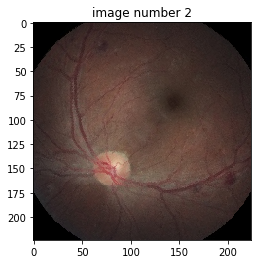

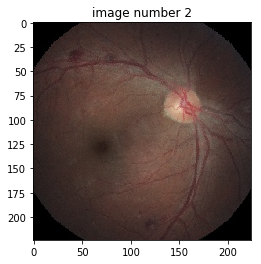

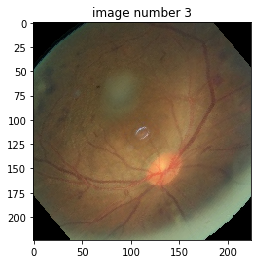

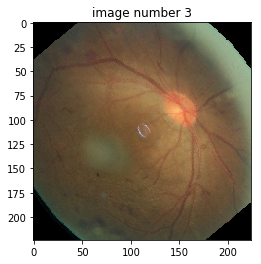

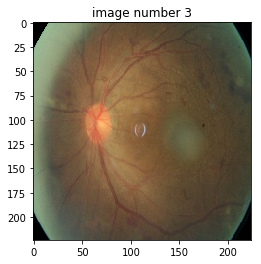

In [0]:
# for i in tqdm(range(4)):
#     imgs, _ = dataset_folder[i]
#     for img in imgs:
#         plt.figure()
#         plt.imshow(img)
#         plt.grid(False)
#         plt.title('image number {}'.format(i))

In [0]:
# # For test purpose
# dataset_dir = 'Dataset/'   # Dataset directory
# root_dir = os.path.join(os.getcwd(), dataset_dir)
# dataset_folder = ImageFolder(root_dir, transform=NRandomCrop(196, 3, 'number'))


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.33it/s]


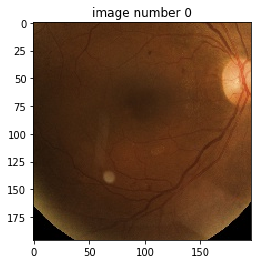

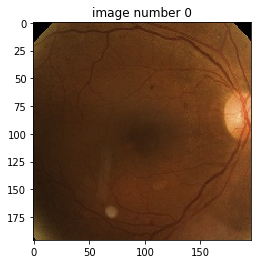

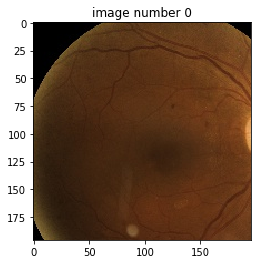

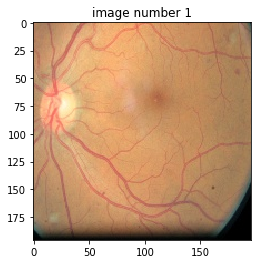

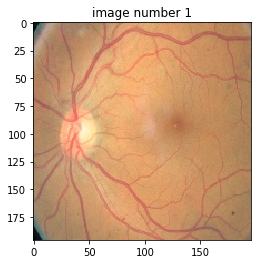

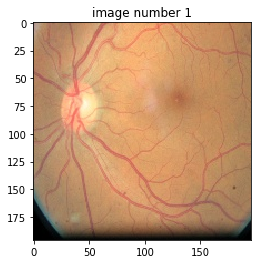

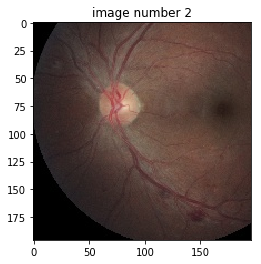

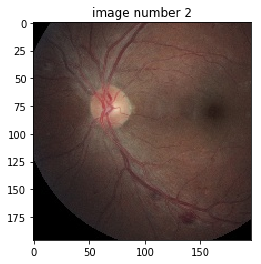

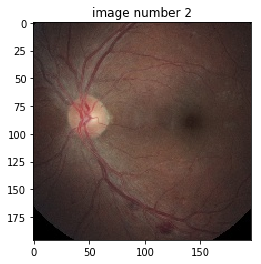

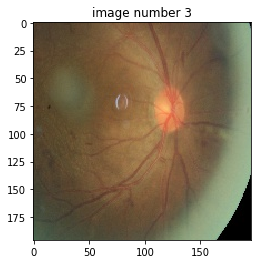

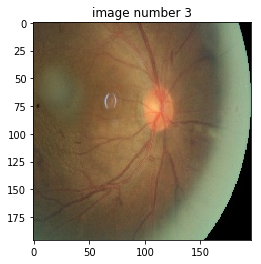

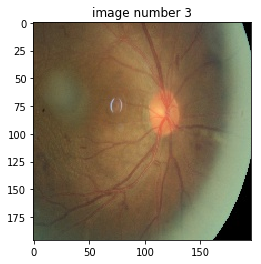

In [0]:
# for i in tqdm(range(4)):
#     imgs, _ = dataset_folder[i]
#     for img in imgs:
#         plt.figure()
#         plt.imshow(img)
#         plt.grid(False)
#         plt.title('image number {}'.format(i))